#Handling the MNIST dataset and data preprocessing

In [ ]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

In [ ]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#

training_images_filepath = 'train-images.idx3-ubyte'
training_labels_filepath = 'train-labels.idx1-ubyte'
test_images_filepath = 't10k-images.idx3-ubyte'
test_labels_filepath = 't10k-labels.idx1-ubyte'

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train_total, y_train_total), (x_test, y_test) = mnist_dataloader.load_data()

In [ ]:
print(len(x_train_total))

60000


###Printing out some sample images

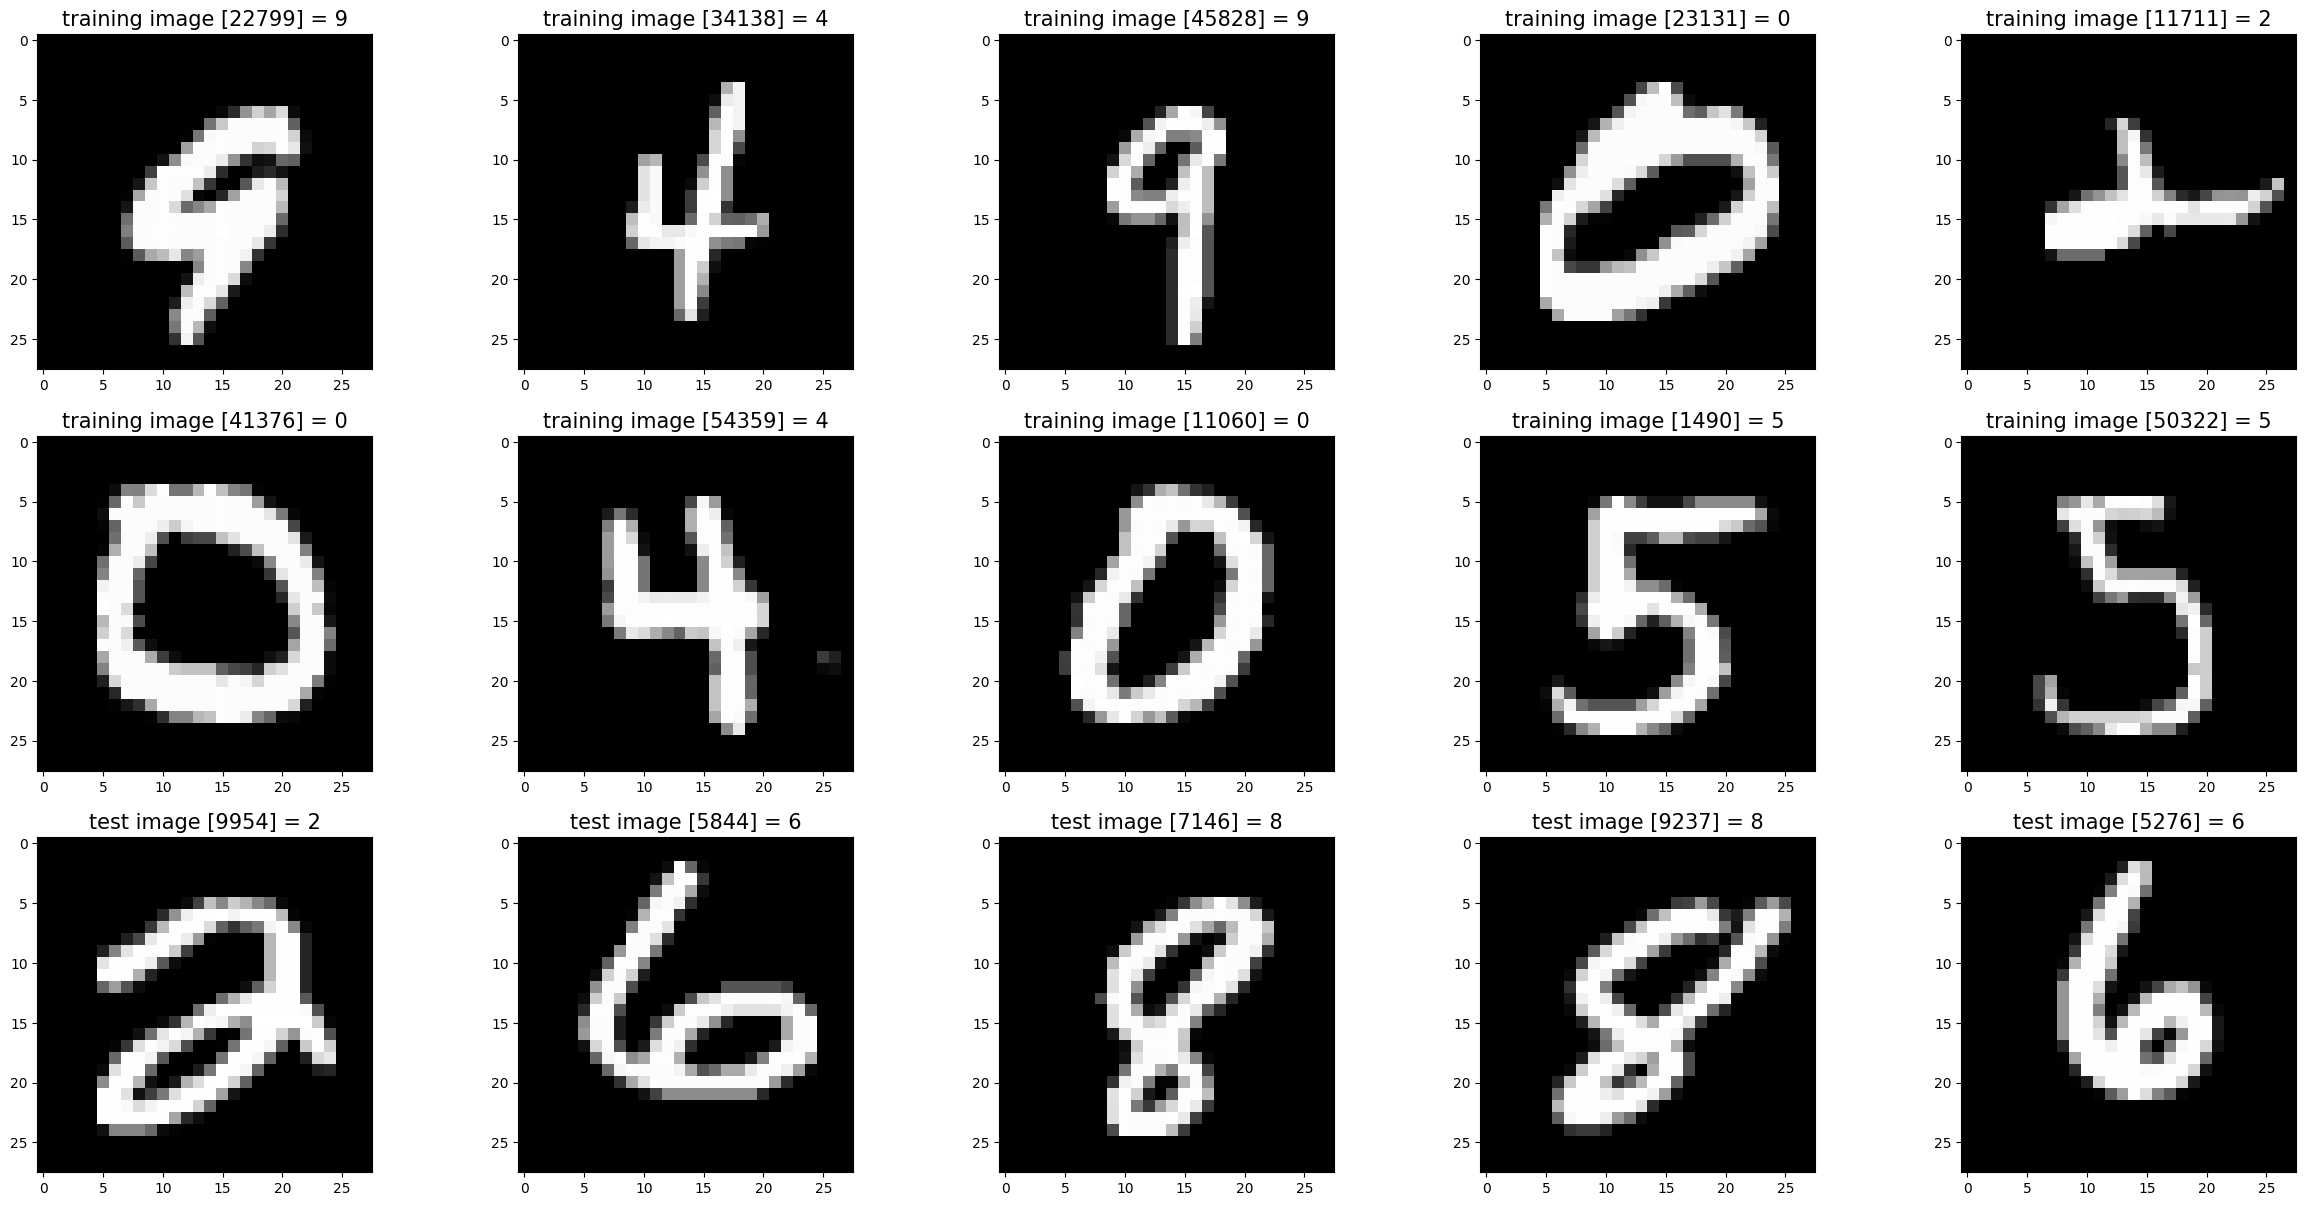

In [ ]:
#
# Show some random training and test images
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train_total[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train_total[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

show_images(images_2_show, titles_2_show)

###splitting train data into training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_validation, y_train, y_validation = train_test_split(x_train_total, y_train_total, test_size=0.2, stratify=y_train_total)
print(type(y_train))


<class 'list'>


###checking the size of each set

In [ ]:
print(len(x_train))

48000


In [ ]:
print(len(x_validation))

12000


In [ ]:
print(len(x_test))

10000


##Applying feature scaling, dealing with tensors, and creating Dataloaders

In [ ]:
# Applying feature sclaةing
import torch
from torch.utils.data import DataLoader, TensorDataset
x_train = np.divide(x_train, 255.0)
x_validation = np.divide(x_validation, 255.0)
x_test = np.divide(x_test, 255.0)

# Convert numpy arrays to tensors
x_train_tensor = torch.from_numpy(x_train)
y_train_tensor = torch.from_numpy(np.array(y_train))

x_validation_tensor = torch.from_numpy(x_validation)
y_validation_tensor = torch.from_numpy(np.array(y_validation))

x_test_tensor = torch.from_numpy(x_test)
y_test_tensor = torch.from_numpy(np.array(y_test))

# Create a TensorDataset
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
validation_dataset = TensorDataset(x_validation_tensor, y_validation_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create a DataLoader
batch_size = 10
training_set = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_set = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_set = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


#Setting up basic Neural Network architechture

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(28*28, 64)
        self.fc2=nn.Linear(64, 64)
        self.fc3=nn.Linear(64, 64)
        self.fc4=nn.Linear(64, 32)
        self.fc5=nn.Linear(32, 10)

    def forward(self,x):
        h1=F.relu(self.fc1(x))
        h2=F.relu(self.fc2(h1))
        h3=F.relu(self.fc3(h2))
        h4=F.relu(self.fc4(h3))
        y=self.fc5(h4)
        return F.log_softmax(y,dim=1)

# Training model and calculating loss and accuracy for training and validation sets

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader


model =Net()

# setting loss function to cross entropy
criterion=nn.CrossEntropyLoss()

# setting optimizer to Stocastic gradient descent
optimizer=optim.SGD(model.parameters(),lr=0.01)

training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

epochs = 5

# training the model and getting final loss in each epoch
for epoche in range(epochs):
    epoch_training_loss = 0
    epoch_validation_loss = 0

    for data in training_set:
        X,y=data
        X=X.float()
        model.zero_grad()
        y_pred=model(X.view(-1,28*28))
        batch_loss=criterion(y_pred,y)
        batch_loss.backward()
        optimizer.step()

    # getting the average loss across all training set batches
    for data in training_set:
      X,y=data
      X=X.float()
      y_pred=model(X.view(-1,28*28))
      batch_loss=criterion(y_pred,y)
      epoch_training_loss += batch_loss.item()
    training_loss.append(epoch_training_loss / len(training_set))

    # getting the average loss across all validation set batches
    for data in validation_set:
      X,y=data
      X=X.float()
      y_pred=model(X.view(-1,28*28))
      batch_loss=criterion(y_pred,y)
      epoch_validation_loss += batch_loss.item()
    validation_loss.append(epoch_validation_loss / len(validation_set))

    train_correct=0
    train_total=0
    validate_correct=0
    validate_total=0

    # getting current epoch accuracy on training data
    with torch.no_grad():
        for data in training_set:
            X,y=data
            X=X.float()
            y_pred=model(X.view(-1,28*28))
            for idx,i in enumerate(y_pred):
                if torch.argmax(i)==y[idx]:
                    train_correct+=1
                train_total+=1

    # getting current epoch accuracy on validation data
    with torch.no_grad():
        for data in validation_set:
            X,y=data
            X=X.float()
            y_pred=model(X.view(-1,28*28))
            for idx,i in enumerate(y_pred):
                if torch.argmax(i)==y[idx]:
                    validate_correct+=1
                validate_total+=1

    training_accuracy.append(train_correct / train_total * 100)
    validation_accuracy.append(validate_correct / validate_total * 100)

##Plotting training and validation loss

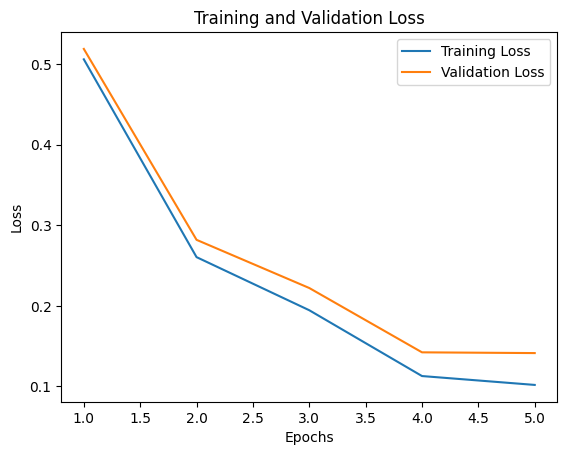

In [ ]:
x_axis = range(1, epochs + 1)
plt.plot(x_axis, training_loss, label = 'Training Loss')
plt.plot(x_axis, validation_loss, label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

##Plotting training and validation accuracy

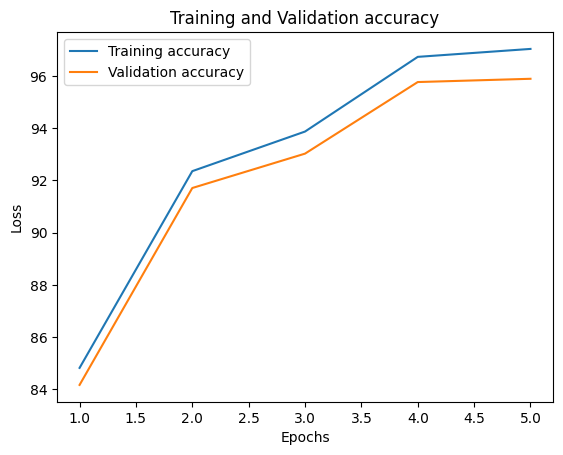

In [ ]:
x_axis = range(1, epochs + 1)
plt.plot(x_axis, training_accuracy, label = 'Training accuracy')
plt.plot(x_axis, validation_accuracy, label = 'Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

##Getting final accuracy score on test set

In [ ]:
correct=0
total=0

with torch.no_grad():
    for data in test_set:
        X,y=data
        X=X.float()
        output=model(X.view(-1,28*28))
        for idx,i in enumerate(output):
            if torch.argmax(i)==y[idx]:
                correct+=1
            total+=1
print('accuracy on test set',correct/total *100 ,"%")

accuracy on test set 95.97 %


#Analysis to get the best batch size


Training the neural network for three epochs using different batch sizes and recording the accuracy after the third epoch for each batch size. The batch size that yields the highest accuracy on the validation set after the third epoch is considered the "best" batch size.

In [ ]:
### changing batch sizes to get the best
import torch.optim as optim
from torch.utils.data import DataLoader

batches=[10,20,32,64,128,256]
AccForBatches=[]

for j in range(0,len(batches)):
  training_set = DataLoader(train_dataset, batch_size=batches[j], shuffle=True)
  validation_set = DataLoader(validation_dataset, batch_size=batches[j], shuffle=True)
  model = Net()

  # setting loss function to cross entropy
  criterion=nn.CrossEntropyLoss()

  # setting optimizer to Stocastic gradient descent
  optimizer=optim.SGD(model.parameters(),lr=0.01)

  training_loss = []
  training_accuracy = []


  epochs = 3

  # training the model and getting final loss in each epoch
  for epoche in range(epochs):
      epoch_training_loss = 0

      for data in training_set:
          X,y=data
          X=X.float()
          model.zero_grad()
          y_pred=model(X.view(-1,28*28))
          batch_loss=criterion(y_pred,y)
          batch_loss.backward()
          optimizer.step()

      # getting the average loss across all training set batches
      for data in training_set:
        X,y=data
        X=X.float()
        y_pred=model(X.view(-1,28*28))
        batch_loss=criterion(y_pred,y)
        epoch_training_loss += batch_loss.item()
      training_loss.append(epoch_training_loss / len(training_set))

      train_correct=0
      train_total=0

      # getting current epoch accuracy on training data
      with torch.no_grad():
          for data in training_set:
              X,y=data
              X=X.float()
              y_pred=model(X.view(-1,28*28))
              for idx,i in enumerate(y_pred):
                  if torch.argmax(i)==y[idx]:
                      train_correct+=1
                  train_total+=1

      training_accuracy.append(train_correct / train_total * 100)

  AccForBatches.append(training_accuracy[2])

print(AccForBatches)
best_batch = batches[AccForBatches.index(max(AccForBatches))]

[95.27083333333334, 91.29374999999999, 85.23541666666667, 65.23541666666667, 20.772916666666667, 15.608333333333333]


#Analysis to get the best learning rate


Iterating over different learning rates and training the neural network using the best batch size obtained in the previous step. The goal is to find the learning rate that results in the highest accuracy on the training set after the fourth epoch.

In [ ]:
import math

## use best batch to get best learning rate


LRates=[0.001,.005,0.01,0.05,0.07,0.1,0.3]
AccForLRates=[]

for j in range(0,len(batches)):
  training_set = DataLoader(train_dataset, batch_size=10, shuffle=True)
  validation_set = DataLoader(validation_dataset, batch_size=10, shuffle=True)
  model = Net()

  # setting loss function to cross entropy
  criterion=nn.CrossEntropyLoss()

  # setting optimizer to Stocastic gradient descent
  optimizer=optim.SGD(model.parameters(),lr=LRates[j])

  training_loss = []
  training_accuracy = []


  epochs = 4

  # training the model and getting final loss in each epoch
  for epoche in range(epochs):
      epoch_training_loss = 0

      for data in training_set:
          X,y=data
          X=X.float()
          model.zero_grad()
          y_pred=model(X.view(-1,28*28))
          batch_loss=criterion(y_pred,y)
          batch_loss.backward()
          optimizer.step()

      # getting the average loss across all training set batches
      for data in training_set:
        X,y=data
        X=X.float()
        y_pred=model(X.view(-1,28*28))
        batch_loss=criterion(y_pred,y)
        epoch_training_loss += batch_loss.item()
      training_loss.append(epoch_training_loss / len(training_set))

      train_correct=0
      train_total=0

      # getting current epoch accuracy on training data
      with torch.no_grad():
          for data in training_set:
              X,y=data
              X=X.float()
              y_pred=model(X.view(-1,28*28))
              for idx,i in enumerate(y_pred):
                  if torch.argmax(i)==y[idx]:
                      train_correct+=1
                  train_total+=1

      training_accuracy.append(train_correct / train_total * 100)

  AccForLRates.append(training_accuracy[3])
  print(AccForLRates)

print(AccForLRates)


[45.53333333333333]
[45.53333333333333, 93.90625]
[45.53333333333333, 93.90625, 96.57291666666666]
[45.53333333333333, 93.90625, 96.57291666666666, 97.83333333333334]
[45.53333333333333, 93.90625, 96.57291666666666, 97.83333333333334, 97.97916666666666]
[45.53333333333333, 93.90625, 96.57291666666666, 97.83333333333334, 97.97916666666666, 97.46041666666667]
[45.53333333333333, 93.90625, 96.57291666666666, 97.83333333333334, 97.97916666666666, 97.46041666666667]


#Introducing Dropout layer and Layer normalization to our model



*   Dropout is a regularization technique used to prevent overfitting in neural networks by randomly setting a fraction of input units to zero during each training iteration.
*   This helps in reducing interdependency among neurons, forcing the network to learn more robust features.


---



*   Layer normalization is a technique used to normalize the inputs to a layer in a neural network. It normalizes the activations across features, helping in reducing internal covariate shift and aiding faster convergence





##New network architecture



In [ ]:
# editiing network architecture to insert dropout layer and layer normalization

class new_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(28*28, 64)
        self.fc2=nn.Linear(64, 64)
        self.fc3=nn.Linear(64, 64)
        self.fc4=nn.Linear(64, 32)
        self.fc5=nn.Linear(32, 10)

        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.20)


        # Define layer normalization layers
        self.layer_norm1 = nn.LayerNorm(64)
        self.layer_norm2 = nn.LayerNorm(64)
        self.layer_norm3 = nn.LayerNorm(64)
        self.layer_norm4 = nn.LayerNorm(32)

    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.layer_norm1(x) # first layer normalization after first hidden layer
        x = self.dropout(x)  # Apply dropout after layer normalization
        x = F.relu(self.fc2(x))
        x = self.layer_norm2(x) # second layer normalization after second hidden layer
        x = self.dropout(x)  # Apply dropout after layer normalization
        x = F.relu(self.fc3(x))
        x = self.layer_norm3(x) # third layer normalization after third hidden layer
        x = self.dropout(x)  # Apply dropout after layer normalization
        x = F.relu(self.fc4(x))
        x = self.layer_norm4(x) # fourth layer normalization after fourth hidden layer
        x = self.dropout(x)  # Apply dropout after layer normalization
        x = self.fc5(x)
        return F.log_softmax(x, dim=1)

##Training the new network

In [ ]:
new_model = new_Net()
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(new_model.parameters(),lr=0.01)
epochs = 5

# training the model and getting final loss in each epoch
for epoche in range(epochs):
    for data in training_set:
        X,y=data
        X=X.float()
        new_model.zero_grad()
        y_pred=new_model(X.view(-1,28*28))
        batch_loss=criterion(y_pred,y)
        batch_loss.backward()
        optimizer.step()

##Calculating accuracy of new model on training and test data and comparing them with those of the old model

In [ ]:
train_correct=0
train_total=0
test_correct=0
test_total=0

# getting current epoch accuracy on training data
with torch.no_grad():
    for data in training_set:
        X,y=data
        X=X.float()
        y_pred=new_model(X.view(-1,28*28))
        for idx,i in enumerate(y_pred):
            if torch.argmax(i)==y[idx]:
                train_correct+=1
            train_total+=1

# getting current epoch accuracy on test data
with torch.no_grad():
    for data in test_set:
        X,y=data
        X=X.float()
        y_pred=new_model(X.view(-1,28*28))
        for idx,i in enumerate(y_pred):
            if torch.argmax(i)==y[idx]:
                test_correct+=1
            test_total+=1

new_training_accuracy = train_correct / train_total * 100
new_test_accuracy = test_correct / test_total * 100


print(f"Accuracy of new model on training set: {new_training_accuracy} %")
print(f"Accuracy of new model on test set: {new_test_accuracy} %")

Accuracy of new model on training set: 94.675 %
Accuracy of new model on test set: 94.05
